# M2177.003100 Deep Learning Assignment #2 <br> Part 2: Text-to-Image Synthesis

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them.

**For understanding of this work, please carefully look at given PDF file.**

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

## 0. What is the Stable Diffusion?

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and runs on a GPU with at least 10GB VRAM.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

Let's get started!

## 1. Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster.

In [1]:
!nvidia-smi

Wed Dec  6 13:53:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.02              Driver Version: 536.19       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     On  | 00000000:01:00.0  On |                  N/A |
| 30%   59C    P0              71W / 200W |   1881MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Next, you should install necessary libraries

In [2]:
!pip install --quiet --upgrade diffusers transformers scipy mediapy accelerate ftfy spacy

## 2. Load the model (Stable Diffusion Pipeline)

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained` method.
Make sure you have succesfully login so that it can be verified that you have indeed accepted the model's license.

We're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`.

If you want to ensure the highest possible precision, please make sure to remove `revision="fp16"` and `torch_dtype=torch.float16` at the cost of a higher memory usage.

In [3]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers import PNDMScheduler, DDIMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler

device = "cuda"
model_id = "CompVis/stable-diffusion-v1-4"
IMAGE_SIZE = 512

scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision="fp16",
    )
pipe = pipe.to(device)

/home/cjpark/anaconda3/envs/deep-learning-23/lib/python3.9/site-packages/diffusers/pipelines/pipeline_utils.py:263: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/cjpark/anaconda3/envs/deep-learning-23/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## 3. Generate the image from the text

Below cell is an example to generate the images from the text 'a photo of nike air jordan shoes' with hyperparameters which are set by using default values in the paper.

There are four hyperparameters you can change to generate the high quality images from the text
* `GUIDANCE_SCALE` : It is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. In simple terms, this hyperparameter forces the generation to better match with the prompt. This can also control the trade-off between the quality and diversity.
Numbers like `7` or `8.5` give good results, if you use a very large number the images might look good, but will be less diverse.

* `NUM_DENOISING_STEPS` : It means how many denoising steps you excute to generate images from the pure Gaussian noise. In general, results are better the more steps you use while more steps make the longer generation process. Stable Diffusion, being one of the latest models, works great with a relatively small number of steps, so we recommend to use the default of `50`. If you want faster results you can use a smaller number. <font color=red>**You should use value smaller than 1000.**</font>

* `SEED` : For the deterministic output, pass a random seed to the pipe line. Every time you use the same seed, you'll have the same image result.

In [4]:
NUM_IMAGES = 4

prompt = "a photo of nike air jordan shoes"
GUIDANCE_SCALE = 7.5
NUM_DENOISING_STEPS = 50
SEED = 1234


images = pipe(
    prompt,
    num_images_per_prompt=NUM_IMAGES,
    guidance_scale=GUIDANCE_SCALE,
    num_inference_steps=NUM_DENOISING_STEPS,
    height=IMAGE_SIZE,
    width=IMAGE_SIZE,
    generator=torch.Generator('cuda').manual_seed(SEED),
    ).images

  0%|          | 0/50 [00:00<?, ?it/s]

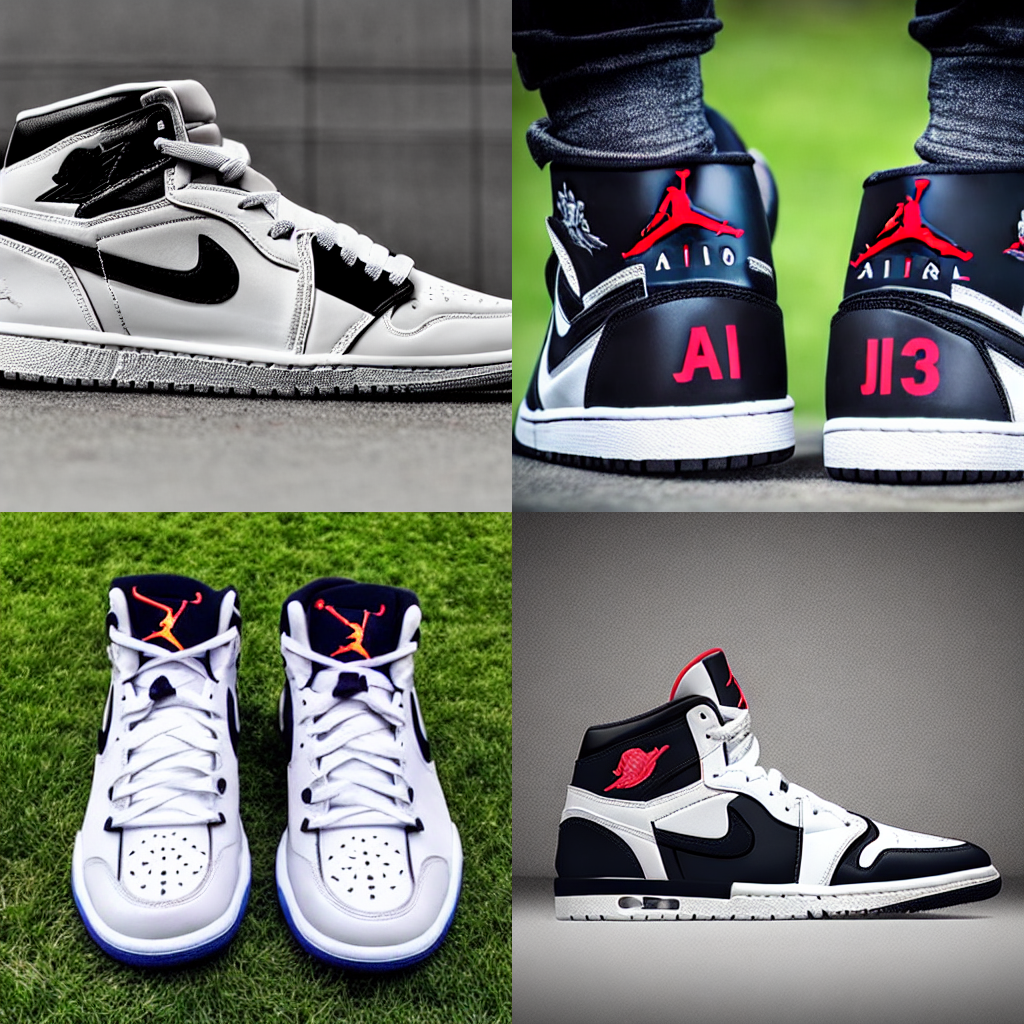

In [5]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

grid = image_grid(images, rows=2, cols=2)
grid

Now, it's time to generate images from your own text and hyperparameters.

help yourself to use any values and text and submit the most creative and best results!

  0%|          | 0/50 [00:00<?, ?it/s]

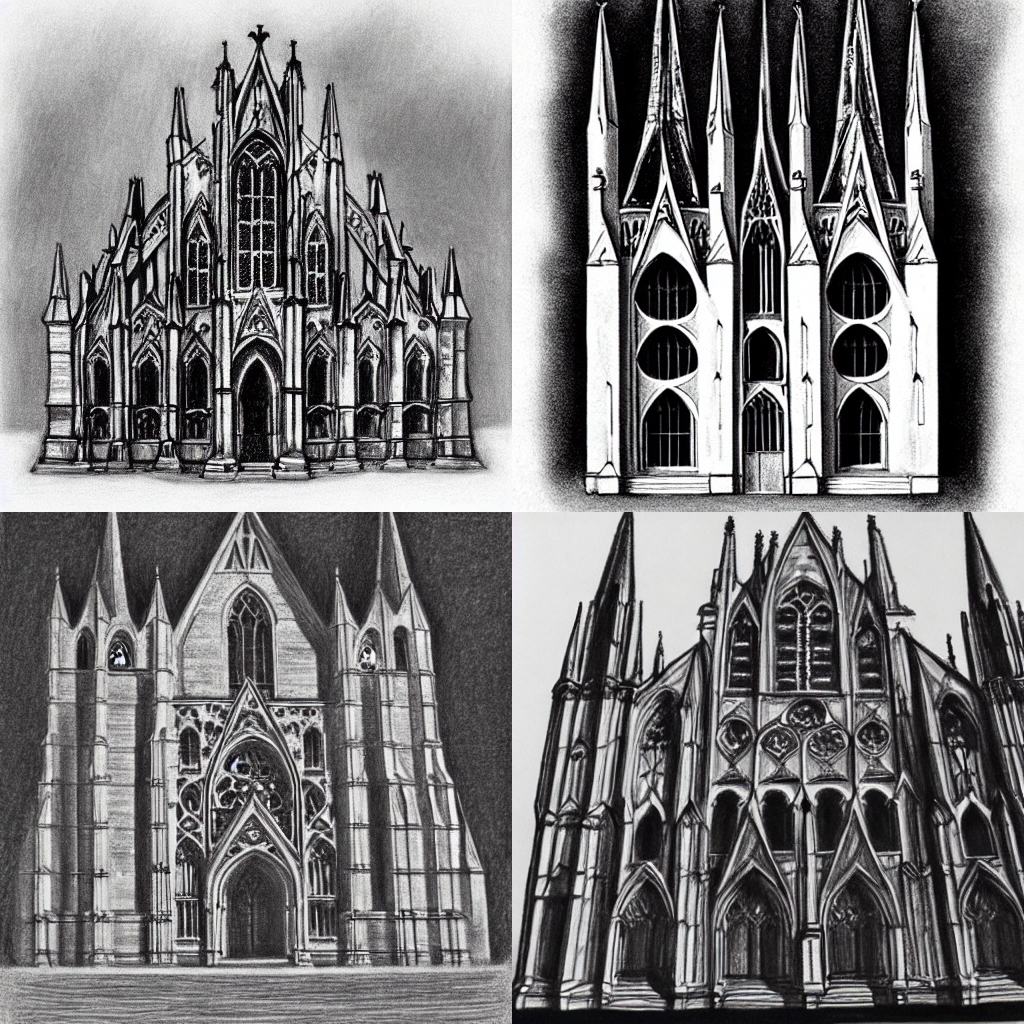

In [15]:
NUM_IMAGES = 4

prompt = "A pencil drawing of gothic style cathedral" # Target Text
GUIDANCE_SCALE = 7.5 # hyperparameter to control the trade-off between generation diversity and quality
NUM_DENOISING_STEPS = 50 # hyperparameter to control the trade-off between the speed and quality
SEED = 12354 # random seed setting for stochasticity in denoising step


images = pipe(
    prompt,
    num_images_per_prompt=NUM_IMAGES,
    guidance_scale=GUIDANCE_SCALE,
    num_inference_steps=NUM_DENOISING_STEPS,
    height=IMAGE_SIZE,
    width=IMAGE_SIZE,
    generator=torch.Generator('cuda').manual_seed(SEED),
    ).images

grid = image_grid(images, rows=2, cols=2)
grid


In [16]:
import os

out_dir = './stable_diffusion_result'
os.makedirs(out_dir, exist_ok=True)

for i, x in enumerate(images):
    x.save(os.path.join(out_dir, '%d.png'%(i+1)))